# Preference Shocks to Consumption Utility

This module defines consumption-saving models in which agents have CRRA utility over a unitary consumption good, geometric discounting, who face idiosyncratic shocks to income and to their utility or preferences. That is, this module contains models that extend `ConsIndShockModel` with preference shocks.

`ConsPrefShockModel` currently solves two types of models:
1. An extension of `ConsIndShock`, but with an iid lognormal multiplicative shock each period.
2. A combination of (1) and 1ConsKinkedR1, demonstrating how to construct a new model
   by inheriting from multiple classes.

In [1]:
from time import process_time

import matplotlib.pyplot as plt
import numpy as np

from HARK.ConsumptionSaving.ConsPrefShockModel import (
    KinkyPrefConsumerType,
    PrefShockConsumerType,
)
from HARK.utilities import plot_funcs

mystr = lambda number: f"{number:.4f}"
do_simulation = True

## Consumption-saving with income risk and preference shocks: `PrefShockConsumerType`

`PrefShockConsumerType` agents are very similar to those in the "idiosyncratic shocks" model, except that in `ConsPrefShockModel` an agent receives an iid shock to their preference for consumption at the beginning of each period, before making the consumption decision.

The agent's problem can be written in (normalized) Bellman form as:

\begin{eqnarray*}
v_t(m_t,\eta_t) &=& \max_{c_t} U(c_t,\eta_t) + \beta \mathsf{S}_{t} \mathbb{E} [(\Gamma_{t+1}\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}, \eta_{t+1}) ], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& R/(\Gamma_{t+1}\psi_{t+1}) a_t + \theta_{t+1}, \\
(\psi_{t},\theta_{t}) \sim F_{t}, &\qquad& \mathbb{E} [\psi_t] = 1, \\
U(c,\eta) &=& \frac{(c/\eta)^{1-\rho}}{1-\rho}, ~~~ \eta_t \sim G_{t}, ~~~ \mathbb{E} [\eta_t] = 1.
\end{eqnarray*}


The one period problem for this model is solved by the function `solveConsPrefShock`, which creates an instance of the class `ConsPrefShockSolver`. The class `PrefShockConsumerType` extends `IndShockConsumerType` to represents agents in this model.

Note that the utility function was slightly revised after HARK 0.17.0. Previously, $\eta$ was applied as a multiplicative factor outside the CRRA exponentiation, but it has been moved inside the parentheses now, as a divisor. With default $\rho = 2$, this actually has no effect at all on the model solution. When using greater values of $\rho$, the scale of preference shocks needed to attain a given level of variation in $c_t$ will no longer scale with $\rho$.

### Additional parameter values to solve an instance of `PrefShockConsumerType`

To construct an instance of this class, there are 3 additional parameters beyond `IndShockConsumerType`, as shown in the table below (parameters can be either "primitive" if they are directly specified by the user or "constructed" if they are built by a class method using simple parameters specified by the user).

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $N{\eta}$ |Number of discrete points in "body" of preference shock distribution  | `PrefShkCount` | 12 |$\surd$ |
| $N{\eta}$ |Number of discrete points in "tails" of preference shock distribution  |`PrefShk_tail_N` |4|$\surd$ |
| $\sigma_{\eta}$ |Log standard deviation of multiplicative utility shocks  | `PrefShkStd` | [0.30] |$\surd$ |



### Constructed inputs to solve a `PrefShockConsumerType`

* The tails of the preference shock distribution are of great importance for the accuracy of the solution and are underrepresented by the default equiprobable discrete approximation (unless a very large number of points are used).
To fix this issue, the attribute `PrefShk_tail_N` specifies the number of points in each "augmented tail" section of the preference shock discrete approximation.

* The standard deviation of preference shocks might vary by period. Therefore, `PrefShkStd` should be input as a list.

Note that the `solve` method of `PerfShockConsumerType` populates the `solution` with a list of `ConsumerSolution` instances. These single-period-solution objects have the same attributes as the "idiosyncratic shocks" model, but the attribute `cFunc` is defined over the space of ($m_{t}$, $\eta_{t}$) rather than just $m_{t}$.

The value function `vFunc` and marginal value `vPfunc`, however, are defined *only* over $m_{t}$, as they represent expected (marginal) value *just before* the preference shock $\eta_{t}$ is realized.

### Example implementation of `PrefShockConsumerType`

Like other HARK `AgentType` subclasses, `PrefShockConsumerType` includes reasonable default parameters and can be instantiated without passing any additional information. Let's make an infinite horizon agent with default parameters, but request the solver to build the value function.

In [2]:
# Make and solve a preference shock consumer
PrefShockExample = PrefShockConsumerType(
    cycles=0, vFuncBool=True
)  # default parameters, infinite horizon

In [3]:
t_start = process_time()
PrefShockExample.solve()
t_end = process_time()
print("Solving a preference shock consumer took " + str(t_end - t_start) + " seconds.")

Solving a preference shock consumer took 1.953125 seconds.


Consumption functions at each discrete shock:


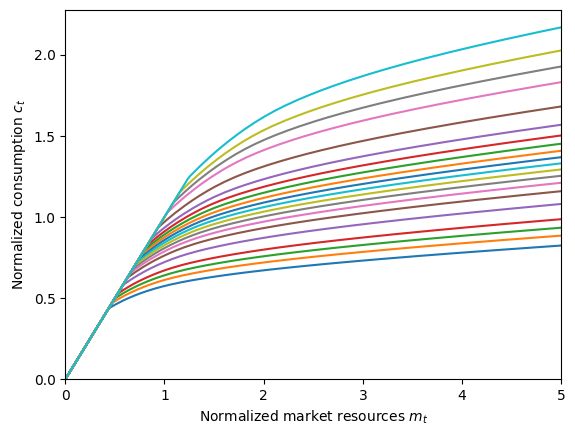

In [4]:
# Plot the consumption function at each discrete shock
m = np.linspace(PrefShockExample.solution[0].mNrmMin, 5, 200)
print("Consumption functions at each discrete shock:")
for j in range(PrefShockExample.PrefShkDstn[0].pmv.size):
    PrefShk = PrefShockExample.PrefShkDstn[0].atoms.flatten()[j]
    c = PrefShockExample.solution[0].cFunc(m, PrefShk * np.ones_like(m))
    plt.plot(m, c)
plt.xlim([0.0, 5.0])
plt.ylim([0.0, None])
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.show()

Value function (unconditional on shock):


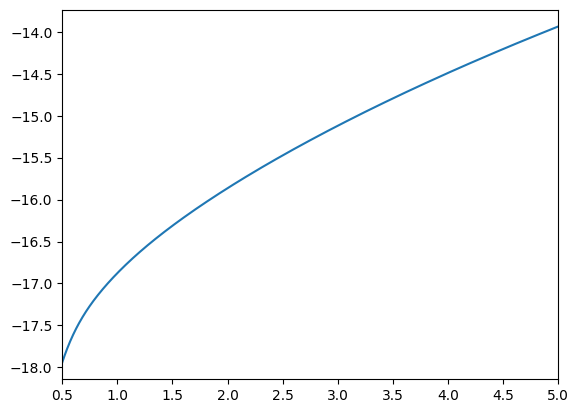

In [5]:
if PrefShockExample.vFuncBool:
    print("Value function (unconditional on shock):")
    plot_funcs(
        PrefShockExample.solution[0].vFunc,
        PrefShockExample.solution[0].mNrmMin + 0.5,
        5,
    )

In [6]:
# Test the simulator for the pref shock class
if do_simulation:
    PrefShockExample.T_sim = 120
    PrefShockExample.track_vars = ["cNrm"]
    PrefShockExample.initialize_sim()
    PrefShockExample.simulate()

## Utility shocks and different interest rates: `KinkyPrefConsumerType`

In this model, an agent faces idiosyncratic shocks to permanent and transitory income and shocks to utility *and* faces a different interst rate on borrowing vs saving. This agent's model is identical to that of the `ConsPrefShockModel` with the addition of the interst rate rule from the `KinkedRConsumerType` from `ConsIndShock` model.

The one period problem of this model is solved by the function `solveConsKinkyPref`, which creates an instance of `ConsKinkyPrefSolver`. The class `KinkyPrefConsumerType` represents agents in this model.

Thanks to HARK's object-oriented approach to solution methods, it is trivial to combine two models to make a new one. In this current case, the solver and consumer classes each inherit from both `KinkedR` and `PrefShock` and only need a trivial constructor function to rectify the differences between the two.

### Constructed inputs to solve a `KinkyPrefConsumerType`

* The attributes required to properly construct an instance of `KinkyPrefConsumerType` are the same as `PrefShockConsumerType`, except that `Rfree` should not be replace with `Rboro` and `Rsave` - like the "kinked R" parent model.

* Also, as in `KinkedR` and `PrefShock`, `KinkyPref` is not yet compatible with cubic spline interpolation of the consumption function.

### Example implementation of `KinkyPrefConsumerType`

As above, let's use default parameters, but make the agent have an infinite horizon and request that the value function be constructed.

In [7]:
# Make and solve a "kinky preferece" consumer, whose model combines KinkedR and PrefShock
KinkyPrefExample = KinkyPrefConsumerType(cycles=0, vFuncBool=True)

In [8]:
t_start = process_time()
KinkyPrefExample.solve()
t_end = process_time()
print("Solving a kinky preference consumer took " + str(t_end - t_start) + " seconds.")

Solving a kinky preference consumer took 1.578125 seconds.


Consumption functions at each discrete shock:


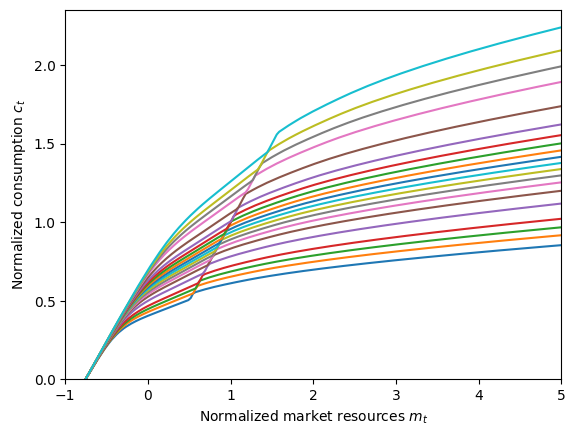

In [9]:
# Plot the consumption function at each discrete shock
m = np.linspace(KinkyPrefExample.solution[0].mNrmMin, 5, 200)
print("Consumption functions at each discrete shock:")
for j in range(KinkyPrefExample.PrefShkDstn[0].atoms.size):
    PrefShk = KinkyPrefExample.PrefShkDstn[0].atoms.flatten()[j]
    c = KinkyPrefExample.solution[0].cFunc(m, PrefShk * np.ones_like(m))
    plt.plot(m, c)
plt.ylim([0.0, None])
plt.xlim(-1.0, 5.0)
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.show()

Value function (unconditional on shock):


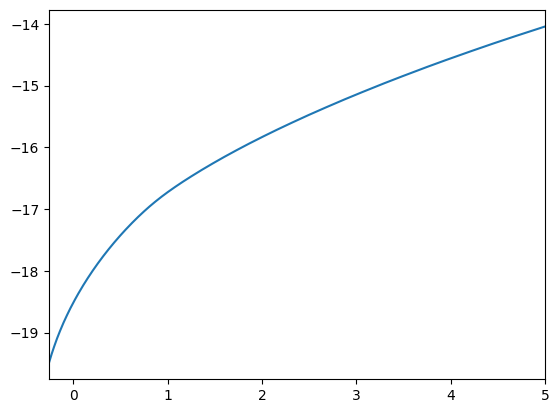

In [10]:
if KinkyPrefExample.vFuncBool:
    print("Value function (unconditional on shock):")
    plot_funcs(
        KinkyPrefExample.solution[0].vFunc,
        KinkyPrefExample.solution[0].mNrmMin + 0.5,
        5,
    )

In [11]:
# Test the simulator for the kinky preference class
if do_simulation:
    KinkyPrefExample.T_sim = 120
    KinkyPrefExample.track_vars = ["cNrm", "PrefShk"]
    KinkyPrefExample.initialize_sim()
    KinkyPrefExample.simulate()